In [6]:

# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import time
import gc
import math

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import hdf5storage
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.fft import fft, fftfreq, fft2, rfft
from scipy.signal import iirnotch, freqz
from scipy.signal import spectrogram

import keras
import shap

In [128]:
# Luca code
def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict

def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=0)
    # Return the filtered LFP signal
    return lfp_filtered

def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    """
    Compute spectrograms for each neuron in EEG data.

    Parameters:
    - data: ndarray of shape (256, 508, num_trials, 5)
    - fs: Sampling frequency
    - nperseg: Length of each FFT segment
    - noverlap: Overlap between segments

    Returns:
    - spectrograms: ndarray of shape (num_total_trials, 256, n_freq_bins, n_time_windows)
    """
    n_neurons, n_time, n_trials, n_classes = data.shape
    all_specs = []

    for cls in range(n_classes):
        for trial in range(n_trials):
            trial_specs = []
            for neuron in range(n_neurons):
                signal = data[neuron, :, trial, cls]
                f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
                trial_specs.append(Sxx)  # Sxx shape: (n_freq_bins, n_time_windows)
            trial_specs = np.stack(trial_specs, axis=0)  # Shape: (256, n_freq_bins, n_time_windows)
            all_specs.append(trial_specs)

    all_specs = np.stack(all_specs, axis=0)  # Shape: (n_total_trials, 256, n_freq_bins, n_time_windows)
    return f, all_specs.transpose(0, 2, 3, 1)

def visualize_spectogram(Sxx, f, t, title = "Example Spectrogram", normalize=True):
    # Normalize each frequency bin by its mean (or max) across time
    if normalize:
        Sxx_max = np.max(Sxx, axis=1, keepdims=True)
        Sxx_min = np.min(Sxx, axis=1, keepdims=True)
        Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
    plt.imshow(Sxx, aspect='auto', origin='lower',
              extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], int(num_yticks/5))
    plt.yticks(yticks, labels=np.round(yticks))

    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    plt.xticks(xticks, labels=np.round(xticks, 3), rotation=45)
    plt.savefig(f"{title}.pdf", format='pdf')
    plt.show()

def clean_spectograms(spectograms, f, remove_freqs, fs, window_size, upper_bound):
    cleaned_spectograms = []
    lower_bound = int(math.ceil(fs / window_size / 10.0) * 10)
    lower_bound_indx = np.where(f >= lower_bound)[0][0]
    upper_bound_indx = np.where(f <= upper_bound)[0][-1]
    mask = (f >= remove_freqs-2) & (f <= remove_freqs+2)
    harmonics = np.arange(remove_freqs, f[-1], remove_freqs)

    for trial in spectograms:
        cleaned_spectogram_per_trial = []
        for channel in trial:
            cleaned_spectogram = channel
            for h in harmonics:
                mask = (f >= h-2) & (f <= h+2)
                cleaned_spectogram[mask, :] = 0
            cleaned_spectogram = cleaned_spectogram[lower_bound_indx:upper_bound_indx]
            cleaned_spectogram_per_trial.append(cleaned_spectogram)
        cleaned_spectograms.append(cleaned_spectogram_per_trial)
    f = f[lower_bound_indx:upper_bound_indx]
    return np.array(cleaned_spectograms), f

In [129]:
# Data loading pipeline

# Load data
print('Loading 1...')
_, epoched1, _ = import_mat('Data/1_data_left_0.mat')
print('Loading 2...')
_, epoched2, _ = import_mat('Data/2_data_left_45.mat')
print('Loading 3...')
_, epoched3, _ = import_mat('Data/3_data_left_90.mat')
print('Loading 4...')
_, epoched4, _ = import_mat('Data/4_data_left_135.mat')
print('Loading 5...')
_, epoched5, _ = import_mat('Data/5_data_right_0.mat')
print('Loading 6...')
_, epoched6, _ = import_mat('Data/6_data_right_45.mat')
print('Loading 7...')
_, epoched7, _ = import_mat('Data/7_data_right_90.mat')
print('Loading 8...')
_, epoched8, _ = import_mat('Data/8_data_right_135.mat')

epoched_left = np.concatenate((epoched1, epoched2, epoched3, epoched4), axis=2)
epoched_right = np.concatenate((epoched5, epoched6, epoched7, epoched8), axis=2)
left_trials = epoched1.shape[2] + epoched2.shape[2] + epoched3.shape[2] + epoched4.shape[2]
right_trials = epoched5.shape[2] + epoched6.shape[2] + epoched7.shape[2] + epoched8.shape[2]

# Delete individual datasets to free memory
del epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8
del _

# Force garbage collection
gc.collect()

# Create spectrograms
print('Making spectrograms...')
fl, specs_left = compute_eeg_spectrograms(epoched_left)
_, specs_right = compute_eeg_spectrograms(epoched_right)

# Create labels
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
zeros = np.zeros(epoched_right.shape[2])
y_part_right = np.repeat(np.arange(5, 9), epoched_right.shape[2])
y_right = np.concatenate([zeros, y_part_right])
y_total = np.concatenate((y_left, y_right), axis=0)

# Clean spectrograms
print('Cleaning data...')
X_total = np.concatenate((specs_left, specs_right), axis=0)
X_total = X_total.transpose(0, 3, 1, 2)
X_final, f = clean_spectograms(X_total, fl, remove_freqs=60, fs=2000, window_size=200, upper_bound=500)
X_final = X_final.transpose(0, 2, 3, 1)

# Remove top channels (list pulled by Luca's code)
channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]
channels_to_keep = [i for i in range(X_final.shape[-1]) if i not in channels_to_remove]
X_final = X_final[:, :, :, channels_to_keep]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_total, test_size=0.2, random_state=42)

del epoched_left, epoched_right, specs_left, specs_right, X_total, X_final, y_total, y_left, y_right
gc.collect()
print('Data loaded.')

Loading 1...
Loading 2...
Loading 3...
Loading 4...
Loading 5...
Loading 6...
Loading 7...
Loading 8...
Making spectrograms...
Cleaning data...
Data loaded.


In [56]:
import numpy as np
import tensorflow as tf
import keras

# ---- Function to compute gradients ----
def get_gradients(img_input, top_pred_idx):
    with tf.GradientTape() as tape:
        tape.watch(img_input)
        preds = model(img_input)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, img_input)
    return grads


# ---- Function to compute Integrated Gradients ----
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros(img_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    img_input = img_input.astype(np.float32)

    # Interpolation
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # Compute gradients for all interpolated images
    grads = []
    for i in range(interpolated_image.shape[0]):
        img = tf.convert_to_tensor(interpolated_image[i:i+1], dtype=tf.float32)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # Approximate integral with trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # Final integrated gradients
    integrated_grads = (img_input[0] - baseline[0]) * avg_grads
    return integrated_grads


# ---- Multiple random baselines ----
def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    integrated_grads = []
    for run in range(num_runs):
        baseline = np.random.random(img_input.shape)
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)


In [162]:
# Defining dictionaries and functions for plotting

regions = {
    'l_PMv': (0, 55),
    'l_PMd': (56, 84),
    'r_PMd': (85, 148),
    'r_PMv': (149, 212),
    'l_M1': (213, 244)
}

region_colors = {
    'l_PMv': '#E69F00',  # orange
    'l_PMd': '#56B4E9',  # sky blue
    'r_PMd': '#009E73',  # green
    'r_PMv': '#F0E442',  # yellow
    'l_M1':  '#CC79A7',  # redish purple
}

bands = {
    'alpha': (0, 1),
    'beta':  (1, 2),
    'low_gamma': (2, 6),
    'high_gamma': (6, 9),
    'low_ripple': (9, 14),
    'high_ripple': (14, 19),
    'multiunit': (19, 49)
}

color_ranges = {
    (0, 1): '#E69F00',  # orange
    (1, 2): '#56B4E9',  # sky blue
    (2, 6): '#009E73',  # green
    (6, 9): '#F0E442',  # yellow
    (9, 14): '#0072B2', # blue
    (14, 19): '#D55E00', # vermilion
    (19, 49): '#CC79A7' # redish purple
}

def get_region_for_channel(channel_idx):
    for region, (start, end) in regions.items():
        if start <= channel_idx <= end:
            return region

In [137]:
# Load model:
model = keras.models.load_model("new_cnn_cleaned_752.keras")

img_size = (49, 4, 245)  # (freq_bins, channels, time_points)

num_samples = 100
X_background_cnn = X_test[np.random.choice(X_test.shape[0], num_samples, replace=False)]

# To store importance per sample
all_igrads_cnn = []

for i in range(num_samples):
    if i % 10 == 0:
        print(f"Processing sample {i+1}/{num_samples}")
    
    # Get sample input
    img_input = np.expand_dims(X_background_cnn[i], axis=0)  # Shape (1, 49, 4, 245)
    
    # Predict label
    preds = model.predict(img_input, verbose=0)
    top_pred_idx = tf.argmax(preds[0])
    
    # Compute IG
    igrads = random_baseline_integrated_gradients(
        img_input=img_input[0],
        top_pred_idx=top_pred_idx,
        num_steps=250,
        num_runs=2
    )
    
    # Save IG
    all_igrads_cnn.append(igrads.numpy())

# Convert to array
all_igrads_cnn = np.array(all_igrads_cnn)  # Shape: (num_samples, 49, 4, 245)


Processing sample 1/100
Processing sample 11/100
Processing sample 21/100
Processing sample 31/100
Processing sample 41/100
Processing sample 51/100
Processing sample 61/100
Processing sample 71/100
Processing sample 81/100
Processing sample 91/100


Top channels (indices): [ 71  69  68  15  64  10   4  63 117 136]
Top channels (original): [79, 77, 76, 20, 72, 15, 8, 71, 128, 147]
Their importance scores: [0.00235958 0.0023083  0.00215973 0.001956   0.00164074 0.00162671
 0.00148127 0.00121175 0.00120806 0.0011482 ]


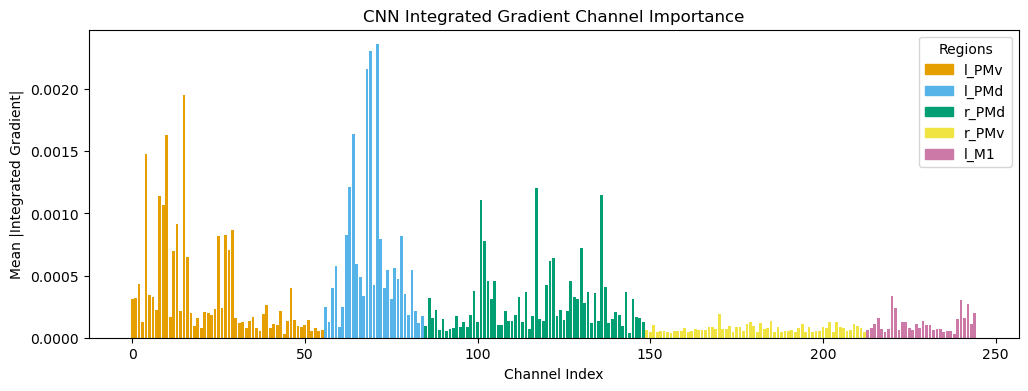

In [175]:
# Get channel importances
importance_channels_cnn = np.mean(np.abs(all_igrads_cnn), axis=(0,1,2))
top_channels = np.argsort(-importance_channels_cnn)[:10]  # Indices of top channels
top_importance_values = importance_channels_cnn[top_channels]  # Corresponding SHAP magnitudes

original_channel_index = []
for i in top_channels:
    original_channel_index.append(channels_to_keep[i])

print("Top channels (indices):", top_channels)
print("Top channels (original):", original_channel_index)
print("Their importance scores:", top_importance_values)

# bar plot of top channels
channel_indices = np.arange(len(importance_channels_cnn))
colors = [region_colors[get_region_for_channel(i)] for i in channel_indices]

plt.figure(figsize=(12, 4))
plt.bar(channel_indices, importance_channels_cnn, color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("CNN Integrated Gradient Channel Importance")
handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
plt.legend(handles, regions.keys(), title="Regions")
plt.savefig("cnn_ig_channels.pdf", format='pdf')
plt.show()

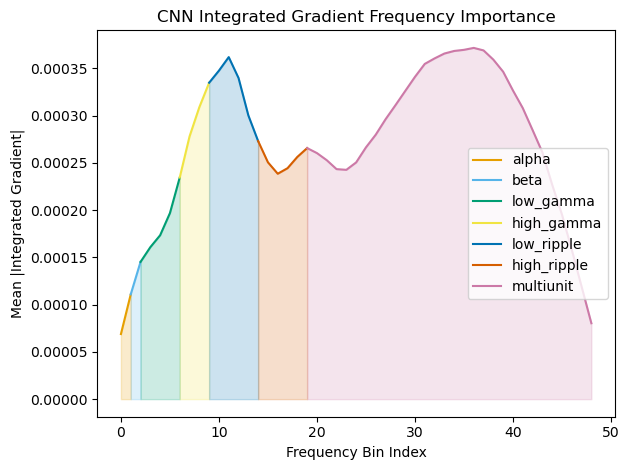

In [159]:
# Frequency importances
cnn_importance_freqs = np.mean(np.abs(all_igrads_cnn), axis=(0,2,3))

for band_name, (f_start, f_end) in bands.items():
    plot_freq_importance = cnn_importance_freqs[f_start:f_end + 1]
    x_values = range(f_start, f_start + len(plot_freq_importance))
    color = color_ranges[(f_start, f_end)]
    plt.plot(x_values, plot_freq_importance, color=color, label=band_name)
    plt.fill_between(x_values, plot_freq_importance, color=color, alpha=0.2)
plt.legend()
plt.xlabel("Frequency Bin Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("CNN Integrated Gradient Frequency Importance")
plt.tight_layout()

plt.savefig("cnn_ig_freqs.pdf", format='pdf')

plt.show()


In [134]:
# Load model:
model = keras.models.load_model("new_cnn_lstm_cleaned_832.keras")

img_size = (49, 4, 245)  # (freq_bins, channels, time_points)

# Get samples for more complete evaluation
num_samples = 100
X_background_lstm = X_test[np.random.choice(X_test.shape[0], num_samples, replace=False)]

# To store importance per sample
all_igrads_l = []

for i in range(num_samples):
    if i % 10 == 0:
        print(f"Processing sample {i+1}/{num_samples}")
    
    # Get sample input
    img_input = np.expand_dims(X_background_lstm[i], axis=0)  # Shape (1, 49, 4, 245)
    
    # Predict label
    preds = model.predict(img_input, verbose=0)
    top_pred_idx = tf.argmax(preds[0])
    
    # Compute IG
    igrads = random_baseline_integrated_gradients(
        img_input=img_input[0],
        top_pred_idx=top_pred_idx,
        num_steps=250,
        num_runs=2
    )
    
    # Save IG
    all_igrads_l.append(igrads.numpy())

# Convert to array
all_igrads_l = np.array(all_igrads_l)  # Shape: (num_samples, 49, 4, 245)


Processing sample 1/100
Processing sample 11/100
Processing sample 21/100
Processing sample 31/100
Processing sample 41/100
Processing sample 51/100
Processing sample 61/100
Processing sample 71/100
Processing sample 81/100
Processing sample 91/100


Top channels (indices): [ 71  15  68  28  64  10 220  58 117  70]
Top channels (original): [79, 20, 76, 34, 72, 15, 231, 66, 128, 78]
Their importance scores: [0.00740351 0.00571307 0.00464699 0.00410732 0.00351271 0.00344951
 0.00337281 0.00296033 0.00293392 0.00282892]


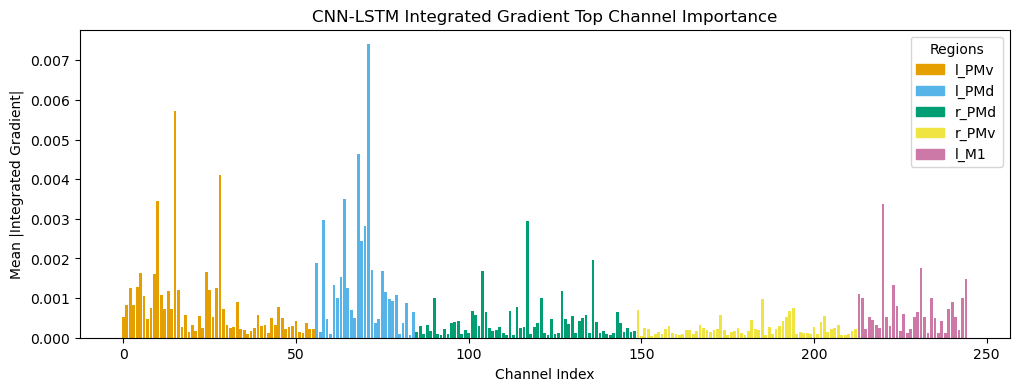

In [182]:
lstm_importance_channels = np.mean(np.abs(all_igrads_l), axis=(0,1,2))
top_channels = np.argsort(-lstm_importance_channels)[:10]  # Indices of top channels
top_importance_values = lstm_importance_channels[top_channels]  # Corresponding SHAP magnitudes

original_channel_index = []
for i in top_channels:
    original_channel_index.append(channels_to_keep[i])

print("Top channels (indices):", top_channels)
print("Top channels (original):", original_channel_index)
print("Their importance scores:", top_importance_values)

# bar plot of top channels
channel_indices = np.arange(len(lstm_importance_channels))
colors = [region_colors[get_region_for_channel(i)] for i in channel_indices]

plt.figure(figsize=(12, 4))
plt.bar(channel_indices, lstm_importance_channels, color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("CNN-LSTM Integrated Gradient Top Channel Importance")
handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
plt.legend(handles, regions.keys(), title="Regions")
plt.savefig("cnn_lstm_ig_channels.pdf", format='pdf')
plt.show()

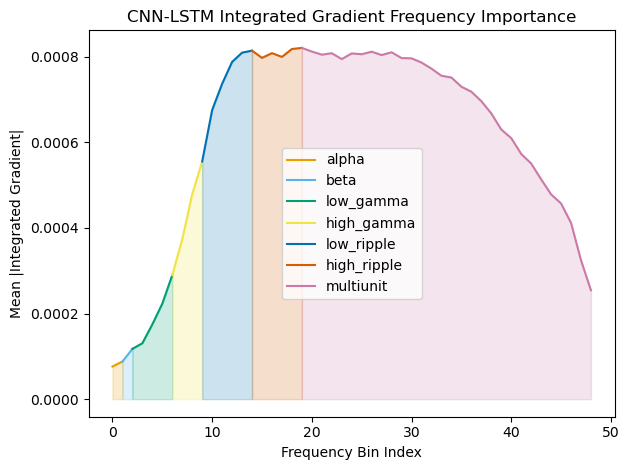

In [161]:
lstm_importance_freqs = np.mean(np.abs(all_igrads_l), axis=(0,2,3))

for band_name, (f_start, f_end) in bands.items():
    plot_freq_importance = lstm_importance_freqs[f_start:f_end + 1]
    x_values = range(f_start, f_start + len(plot_freq_importance))
    color = color_ranges[(f_start, f_end)]
    plt.plot(x_values, plot_freq_importance, color=color, label=band_name)
    plt.fill_between(x_values, plot_freq_importance, color=color, alpha=0.2)
plt.legend()
plt.xlabel("Frequency Bin Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("CNN-LSTM Integrated Gradient Frequency Importance")
plt.tight_layout()

plt.savefig("cnn_lstm_ig_freqs.pdf", format='pdf')

plt.show()


In [130]:
# Load model:
model = keras.models.load_model("new_parallel_cleaned_822.keras")

img_size = (49, 4, 245)  # (freq_bins, channels, time_points)

# Example: test_data shape (num_samples, 49, 4, 245)
num_samples = 100
X_background_parallel = X_test[np.random.choice(X_test.shape[0], num_samples, replace=False)]

# To store importance per sample
all_igrads_p = []

for i in range(num_samples):
    if i % 10 == 0:
        print(f"Processing sample {i+1}/{num_samples}")
    
    # Get sample input
    img_input = np.expand_dims(X_background_parallel[i], axis=0)  # Shape (1, 49, 4, 245)
    
    # Predict label
    preds = model.predict(img_input, verbose=0)
    top_pred_idx = tf.argmax(preds[0])
    
    # Compute IG
    igrads = random_baseline_integrated_gradients(
        img_input=img_input[0],
        top_pred_idx=top_pred_idx,
        num_steps=250,
        num_runs=2
    )
    
    # Save IG
    all_igrads_p.append(igrads.numpy())

# Convert to array
all_igrads_p = np.array(all_igrads_p)  # Shape: (num_samples, 49, 4, 245)


Processing sample 1/100
Processing sample 11/100
Processing sample 21/100
Processing sample 31/100
Processing sample 41/100
Processing sample 51/100
Processing sample 61/100
Processing sample 71/100
Processing sample 81/100
Processing sample 91/100


Top channels (indices): [15 71 69 63 68 64  8 65 72 10]
Top channels (original): [20, 79, 77, 71, 76, 72, 13, 73, 80, 15]
Their importance scores: [0.00420353 0.00411684 0.00408811 0.00365575 0.00305791 0.00290136
 0.00269602 0.00264856 0.00256524 0.00251883]


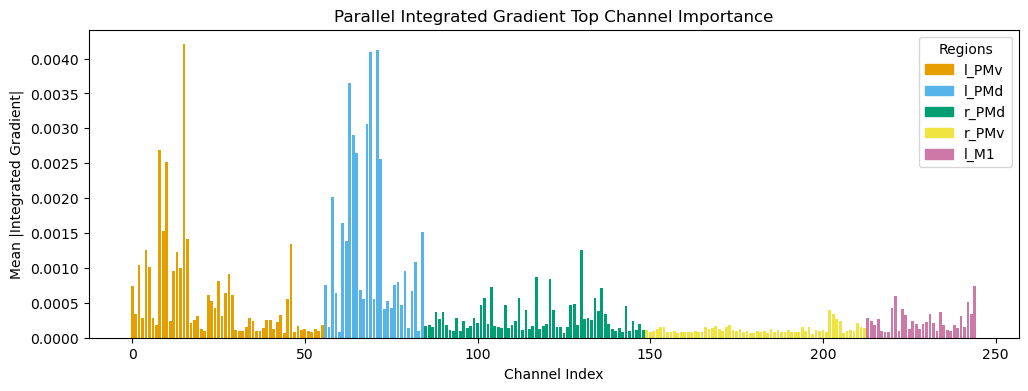

In [181]:
parallel_importance_channels = np.mean(np.abs(all_igrads_p), axis=(0,1,2))

top_channels = np.argsort(-parallel_importance_channels)[:10]  # Indices of top channels
top_importance_values = parallel_importance_channels[top_channels]  # Corresponding SHAP magnitudes

original_channel_index = []
for i in top_channels:
    original_channel_index.append(channels_to_keep[i])


print("Top channels (indices):", top_channels)
print("Top channels (original):", original_channel_index)
print("Their importance scores:", top_importance_values)

# Plot importances
channel_indices = np.arange(len(parallel_importance_channels))
colors = [region_colors[get_region_for_channel(i)] for i in channel_indices]

plt.figure(figsize=(12, 4))
plt.bar(channel_indices, parallel_importance_channels, color=colors)
plt.xlabel("Channel Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("Parallel Integrated Gradient Top Channel Importance")
handles = [plt.Rectangle((0,0),1,1, color=region_colors[label]) for label in regions.keys()]
plt.legend(handles, regions.keys(), title="Regions")
plt.savefig("parallel_ig_channels.pdf", format='pdf')
plt.show()

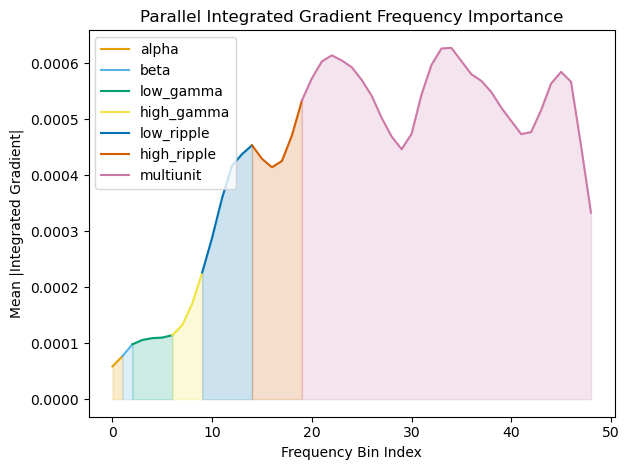

In [160]:
parallel_importance_freqs = np.mean(np.abs(all_igrads_p), axis=(0,2,3))

for band_name, (f_start, f_end) in bands.items():
    plot_freq_importance = parallel_importance_freqs[f_start:f_end + 1]
    x_values = range(f_start, f_start + len(plot_freq_importance))
    color = color_ranges[(f_start, f_end)]
    plt.plot(x_values, plot_freq_importance, color=color, label=band_name)
    plt.fill_between(x_values, plot_freq_importance, color=color, alpha=0.2)
plt.legend()
plt.xlabel("Frequency Bin Index")
plt.ylabel("Mean |Integrated Gradient|")
plt.title("Parallel Integrated Gradient Frequency Importance")
plt.tight_layout()

plt.savefig("parallel_ig_freqs.pdf", format='pdf')

plt.show()
